In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
new_model = tf.keras.models.load_model('FIX\\Model27030\\tf_cnnmodel.hdf5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1499, 64)          8256      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,292,610
Trainable params: 1,292,610
Non-trainable params: 0
______________________________________________

In [39]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [60]:
test_data = pd.read_csv('Data Test (5 Pantai)\\canggu_test_7030.csv', converters={'reviews' : str})
# test_data.drop(["Date", "Content"], axis=1, inplace=True)
# test_data.fillna(0)
# test_data = test_data.fillna("")
test_data.sample(5)

,review,sentiment
142,hot moment also future cozy location beautiful...,1
113,cant understand people come dirty black full g...,0
46,actually special look different atmosphere alr...,0
39,stay 3 day come every morning walk along watch...,1
136,visit club twice cost 100 2 adult 2 kid enter ...,1


In [61]:
try:
    x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
    # x_test = tokenizer
    x_test = pad_sequences(x_test, padding='post', maxlen=1210)
except AttributeError:
    pass

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [62]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.5377716  0.44193098]
 [0.44451487 0.53500307]
 [0.37969562 0.5958217 ]
 [0.43646234 0.54608244]
 [0.53052074 0.45245662]
 [0.34646863 0.6351296 ]
 [0.3375368  0.6401173 ]
 [0.5153261  0.44217598]
 [0.45021278 0.5164214 ]
 [0.5665745  0.40490717]
 [0.45129374 0.52345043]
 [0.43896377 0.5266216 ]
 [0.35946047 0.6197362 ]
 [0.45957696 0.52591705]
 [0.4048074  0.5769484 ]
 [0.33263966 0.6416529 ]
 [0.50042653 0.47554967]
 [0.46708548 0.5044353 ]
 [0.32153952 0.6702823 ]
 [0.3835258  0.59685796]
 [0.52957785 0.413063  ]
 [0.3969641  0.58281475]
 [0.4492235  0.52399546]
 [0.29345787 0.6977734 ]
 [0.49408528 0.44826263]
 [0.46357453 0.50890905]
 [0.4766907  0.4984283 ]
 [0.4373725  0.54476523]
 [0.40760013 0.5553617 ]
 [0.5034305  0.47910783]
 [0.40402865 0.5522486 ]
 [0.40267998 0.56290096]
 [0.53423494 0.43630928]
 [0.48185712 0.48358035]
 [0.5036226  0.47817102]
 [0.41696483 0.5544355 ]
 [0.30615947 0.68858415]
 [0.29037493 0.681111  ]
 [0.44105077 

In [63]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'0',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'1',test_data.pred_sentiment)

In [64]:
labels = ['0', '1']
    
print(classification_report(test_data['sentiment'].values.astype(str),test_data['pred_sentiment'].values,labels=labels))

              precision    recall  f1-score   support

           0       0.09      0.21      0.13        19
           1       0.90      0.77      0.83       175

    accuracy                           0.72       194
   macro avg       0.50      0.49      0.48       194
weighted avg       0.82      0.72      0.76       194



In [65]:
confusion_matrix = pd.crosstab(test_data['sentiment'], test_data['pred_sentiment'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   0    1
Actual            
0           4   15
1          40  135


In [66]:
roc_auc = roc_auc_score(test_data['sentiment'], test_data['pred_sentiment'])

print("ROC AUC Score")
print(roc_auc)

ROC AUC Score
0.4909774436090225


In [183]:
from collections import Counter
import matplotlib.pyplot as plt

In [184]:
# labels = np.array(test_data['pred_sentiment'])

In [185]:
# # df = test_data['pred_sentiment'].value_counts()
# y = []

# for i in range(len(labels)):
#     if labels[i] == '0':
#         y.append('Negative')
#     if labels[i] == '1':
#         y.append('Positive')
# test_data['pred_sentiment'] = np.array(y)
# jumlah = test_data['pred_sentiment'].value_counts()

In [186]:
df = test_data['pred_sentiment'].apply(pd.to_numeric)

In [187]:
df = df.value_counts()

In [188]:
from itertools import cycle, islice
my_colors = list(islice(cycle(['b', 'r']), None, len(df)))

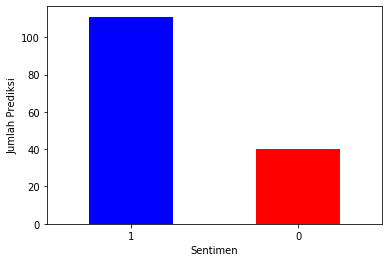

In [189]:
plt.ylabel('Jumlah Prediksi')
plt.xlabel('Sentimen')

df.plot.bar(rot=0, color=my_colors)